In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
coin_ids = {
    'Bitcoin': 1442,
    'Bitcoin Cash': 1445,
    'Bitcoin Gold': 1456,
    'Cardano': 1446,
    'Dash': 1453,
    'Dogecoin': 1447,
    'Eos': 1452,
    'Ethereum': 1443,
    'Ethereum Classic': 1457,
    'Iota': 1451,
    'Lisk': 1460,
    'Litecoin': 1448,
    'Monero': 1454,
    'NEMcoin': 1447,
    'Neo': 1449,
    'Ripple': 1444,
    'Stellar': 1450,
    'Tether': 1474,
    'Tron': 1455,
    'Zcash': 1465,
}

id_coins = {v: k for k, v in coin_ids.items()}

### load data:

In [3]:
iterator_full_data = pd.read_csv('data/datathon.csv', iterator=True, chunksize=100000, parse_dates = ['time'])
subset_full_data = pd.concat([chunk[chunk.refID_coin.isin(coin_ids.values())] for chunk in iterator_full_data])
subset_full_data = subset_full_data.replace({'refID_coin': id_coins})

### There are some duplicate rows, as well as some rows that should exist, but don't:

In [4]:
subset_full_data[subset_full_data[['time', 'refID_coin']].duplicated()].shape

(456, 9)

In [5]:
full_index = pd.MultiIndex.from_product([subset_full_data.time.unique(), subset_full_data.refID_coin.unique()])
subset_full_data = subset_full_data.drop_duplicates(subset = ['time', 'refID_coin']).set_index(['time', 'refID_coin']).reindex(full_index, fill_value = np.nan).reset_index().rename({'level_0': 'time', 'level_1': 'refID_coin'}, axis=1)

### fill missing values:

In [10]:
numeric_cols = ['price', 'marketCap', 'CirculatingSupply', 'Volume24h', 'Movement1h', 'Movement24h']

In [7]:
subset_full_data[numeric_cols] = subset_full_data.groupby('refID_coin')[numeric_cols].transform(lambda x: x.fillna(method='ffill'))

### add moving averages:

In [12]:
for column in numeric_cols:
    for center_of_mass in [10, 50, 288, 1000, 1440, 2880]:
        new_col_name = column + str(center_of_mass)
        ma = subset_full_data.groupby("refID_coin", as_index = False).apply(lambda x: x[column].ewm(com=center_of_mass).mean())
        subset_full_data[new_col_name] = ma.reset_index(level=0, drop=True)

AttributeError: 'DataFrame' object has no attribute 'marketCap_MA_1000'

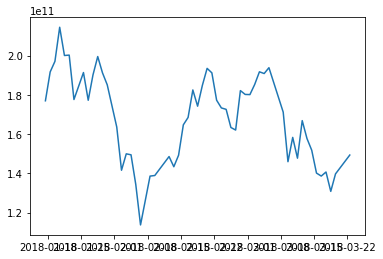

In [13]:
daily = subset_full_data[(subset_full_data.time.dt.minute == 0) & 
                         (subset_full_data.time.dt.hour == 12) &
                         (subset_full_data.refID_coin == 'Bitcoin')]
plt.plot(daily.time, daily.marketCap)
plt.plot(daily.time, daily.marketCap_MA_1000)

In [14]:
daily.marketCap_MA_1000

8652        NaN
371600      NaN
778968      NaN
1193954     NaN
1611150     NaN
2027702     NaN
2424746     NaN
3153396     NaN
3574355     NaN
3996834     NaN
4419636     NaN
4842486     NaN
5264751     NaN
6079083     NaN
6494316     NaN
6922131     NaN
7350976     NaN
7783536     NaN
8214893     NaN
9077526     NaN
9508287     NaN
9688753     NaN
10121081    NaN
10555118    NaN
10744838    NaN
10911884    NaN
11351275    NaN
11792703    NaN
12233028    NaN
12634918    NaN
13073982    NaN
13495496    NaN
13926601    NaN
14354127    NaN
14785523    NaN
14960208    NaN
15392401    NaN
15826456    NaN
16261140    NaN
16625054    NaN
16962115    NaN
17302825    NaN
17633762    NaN
18604266    NaN
18943111    NaN
19284106    NaN
19622884    NaN
19958980    NaN
20300002    NaN
20653549    NaN
21012942    NaN
21369605    NaN
21729325    NaN
22092173    NaN
22463537    NaN
22982295    NaN
Name: marketCap_MA_1000, dtype: object